In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from numba import jit
# from numba.experimental import jitclass

from InputSimulator import make_input, make_pattern_presentation_array, copy_and_paste_jittered_pattern
from InputSimulator import triple_input_runtime, remove_close_spikes, add_noise

## Generating Input

In [20]:
tripling = False
runduration = 50 # [second]
dt = 0.001 # [second]
number_neurons = 2000
number_pat = 1000  # number of neurons that take part in the pattern presentation



T = len(np.arange(dt, runduration, dt))

max_time_wo_spike = 0.05 # [second]
min_rate, max_rate = 0 , 90
max_change_speed = max_rate / max_time_wo_spike # 90/0.05 = 1800 (max_S in paper)
patternlength = 0.05 # [second]
pattern_freq = 0.25


max_rate_add = 10
min_rate_add = 10
max_time_wo_spike_add = 1000
max_change_speed_add = 0

spike_del = 0
jitter_sd = 0

In [21]:
indices, times = make_input(min_rate, max_rate, max_time_wo_spike, max_change_speed, runduration, number_neurons, dt)
position_copypaste = make_pattern_presentation_array(runduration, patternlength, pattern_freq)

In [22]:
len(times), max(times)

(5388631, 49.998999999999995)

In [23]:
def plot_input(times, indices, times_pattern=None, indices_pattern=None):
    time_limit = 0.6
    # time_limit = 0.01
    index_limit = 100
    sampletimes = times[(times < time_limit) & (indices < index_limit)]
    sampleindices = indices[(times < time_limit) & (indices < index_limit)]
    
    # intervals = np.arange(0, 0.61, 0.05)
    intervals = np.arange(0, time_limit+0.01, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < time_limit) & (indices_pattern < index_limit)]
        sampleindicespattern = indices_pattern[(times_pattern < time_limit) & (indices_pattern < index_limit)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    plt.show()

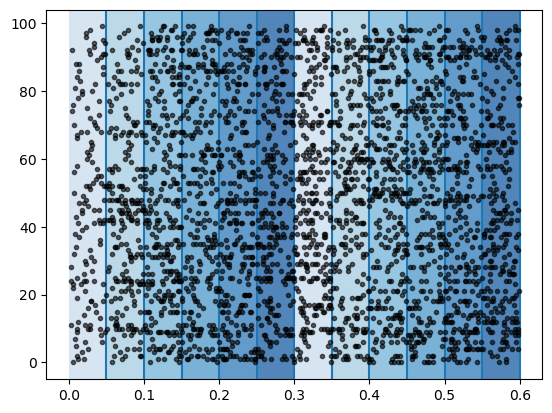

In [24]:
plot_input(times, indices)

In [25]:
indices, times, (indices_pattern, times_pattern) = copy_and_paste_jittered_pattern(times, indices, position_copypaste, patternlength, jitter_sd, spike_del,number_pat)
indices_add, times_add = make_input(min_rate_add, max_rate_add, max_time_wo_spike_add,
                                max_change_speed_add, runduration, number_neurons, dt)
times, indices = add_noise(times, indices, times_add, indices_add)
if tripling and runduration > 300:
        times, indices = triple_input_runtime(times, indices)
        position_copypaste = np.concatenate((position_copypaste, position_copypaste, position_copypaste))
# times, indices = remove_close_spikes(times, indices, dt)
indices = indices.astype(int)

# patneurons = range(0, number_pat)
# nonpatneurons = range(number_pat, number_neurons)

In [8]:
indices_pattern.max()

499.0

In [26]:
def get_dataset():
    spike_train = np.zeros((number_neurons, int(runduration/dt)))
    for time, index in zip(times, indices):
        time = int(time/dt)
        spike_train[index,time] = 1

    weight = np.ones((number_neurons,1)) * 0.475

    return spike_train, weight

spike_train, weight = get_dataset()
spike_train = spike_train[:, :1000]

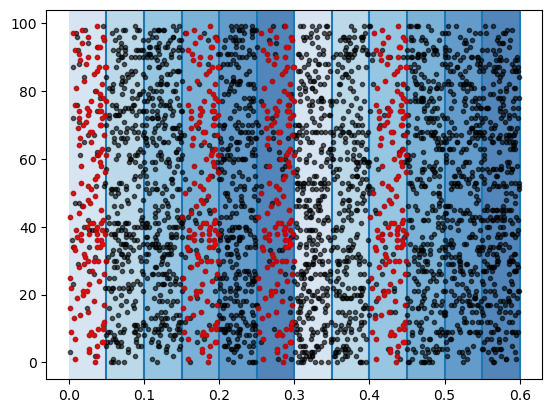

In [10]:
plot_input(times, indices, times_pattern, indices_pattern)

In [45]:
def get_interval_indices():
    """ This function returns the indices in which times array would change from a time interval to the next
    for example if we have index 26 it means, times[25] = 0.000990 and times[26] = 0.00101
    """
    interval_indices = []
    for t in np.arange(dt,runduration+0.001,dt):
        ind = np.searchsorted(times, t)
        interval_indices.append(int(ind))
    # interval_indices = np.array(interval_indices).astype(int)
    interval_indices = np.array(interval_indices)
    return interval_indices

In [21]:
print(np.searchsorted(times, 0.001))
interval_indices = get_interval_indices()
print(times[interval_indices[0]-1: interval_indices[0]+1], 'ms')

0
[] ms


In [27]:
# pretty print matrix A
def pprint(A, precision=2):
    A = np.around(A, decimals=precision)
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA) +' '*(w1-len(str(AAA))+1),end='') # str(AAA)
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='') # str(AA[-1])
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

In [3]:
# class BaseModel:
#     def plot_kernel_(self, kernel, range, step_size):
#         r = np.arange(0,range,step_size)
#         if kernel == 'eta':
#             plt.plot(r/self.dt,self.eta_kernel(r), label=r'\eta kernel')
#             plt.plot(r/self.dt,self.eta_kernel(r), 'xr')
#             plt.axhline(0, linestyle='-', color='black')
#             plt.axhline(min(self.eta_kernel(r)), linestyle='-.', color='black', label='minimum vlaue')
#             plt.axhline(max(self.eta_kernel(r)), linestyle='-.', color='gray', label='maximum value')
#             plt.xlabel(r'$t - t_j$ (ms)')
#             plt.ylabel(r'$\eta (t - t_j)$ kernel')
#             plt.legend()
            
#         elif kernel == 'eps':
#             plt.plot(r/self.dt, self.eps_kernel(r), '--k', label=r'$\varepsilon$ kernel')
#             plt.plot(r/self.dt,self.eps_kernel(r), 'xr')
#             plt.axhline(0, linestyle='-.', color='black', label='minimum vlaue')
#             plt.axhline(1, linestyle='-.', color='gray', label='maximum value')
#             plt.xlabel(r'$t - t_j$ (ms)')
#             plt.ylabel(r'$\varepsilon (t - t_j)$ kernel')
#             plt.legend()
#         else:
#             raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
#     def show_epsilon_matrix_(self, size):
#         def print_epsilon_matrix(matrix):
#             max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
#             column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
#             for row in matrix:
#                 print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
#         matrix = np.empty((2,size), dtype='U40')

#         for i in range(size):
#             # matrix[0, i] = f'epsilon({size-i}ms)'
#             # matrix[1, i] = self.eps_kernel((size-i)*self.dt)
#             matrix[0, i] = f'epsilon({size-i-1}ms)'
#             matrix[1, i] = self.eps_kernel((size-i-1)*self.dt)
#         print_epsilon_matrix(matrix)
    
#     def plot_membrane_potential_(self):
#         plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
#         # if len(self.spike_rec)>0:
#         #     for spk in self.spike_rec:
#         #         plt.axvline(spk/self.dt, linestyle='--', color='gray')
#         plt.axhline(self.threshold, linestyle='dotted', color='orange')
#         plt.axhline(0, linestyle='dotted', color='k')
#         plt.xlabel('Time (ms)')
#         plt.ylabel('Potential (arbitraary units)')


# class SRM(BaseModel):
#     def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, verbose=True) -> None:
#         """_summary_

#         Args:
#             threshold (_type_): _description_
#             tau_m (_type_): _description_
#             tau_s (_type_): _description_
#             K (_type_): _description_
#             K1 (_type_): _description_
#             K2 (_type_): _description_
#             window_size (_type_): _description_
#             verbose (bool, optional): _description_. Defaults to True.
#         """
#         self.threshold = threshold
#         self.tau_m = tau_m
#         self.tau_s = tau_s
#         self.K1 = K1
#         self.K2 = K2
#         self.dt = dt
#         self.window_size = window_size
#         self.tref = tref
#         self.verbose = verbose 
        
#         # initial state of the neuron
#         self.last_spike_time = -1000.000 # seocnd
#         self.spike_rec = []
#         self.potential_rec = []
#         self.ref_counter = 0
#         # TODO: use history to store spike_rec and potential_rec?
#         self.history = {}

#     def eps_kernel(self, s):
#         '''
#         s = t - t_j 
#         time difference between current time and spike time of presynaptic neuron (t_j)
#         Choose K such that the maximum value of epsilon kernel will be 1, based on the paper.
#         '''
#         s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
#         max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
#         self.K = 1 / max_val
#         return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
#     def eta_kernel(self, s):
#         # TODO: figure out if T is actually the threshold value
#         T = self.threshold
#         positive_pulse = self.K1 * np.exp(-s/self.tau_m)
#         negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
#         return T * (positive_pulse - negative_spike_afterpotential)
    
#     def create_epsilon_matrix(self, spike_train):
#         matrix = np.zeros(spike_train.shape)
#         if spike_train.ndim ==1:
#             size = len(spike_train)
#             for it in np.arange(size):
#                 # matrix[it] = self.eps_kernel((size-it)*self.dt)
#                 matrix[it] = self.eps_kernel((size-it-1)*self.dt)
#         else:
#             size = spike_train.shape[1]
#             for it in np.arange(size):
#                 # matrix[:, it] = self.eps_kernel((size-it)*self.dt)
#                 matrix[:, it] = self.eps_kernel((size-it-1)*self.dt)
#         return matrix
    
#     def reset_neuron(self):
#         self.last_spike_time = -1000.000 # seocnd
#         self.spike_rec = []
#         self.potential_rec = []
#         self.ref_counter = 0
    
#     def run(self, spike_train, weight, it):
#         n, total_length = spike_train.shape
        
#         # for it in range(total_length): 
#         ##### moved this block out of the for loop #####          
#         t = it*self.dt

#         # start_widnow = max(0, it+1-self.window_size, int(self.last_spike_time/self.dt))
#         # end_window = it + 1
#         # spike_train_window = spike_train[:, start_widnow:end_window]
#         # epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
#         # eps = spike_train_window * epsilon_matrix
#         # eps_tmp = np.array(eps)
#         # eps = np.sum(eps, axis=1, keepdims=True)
#         # eps = eps * weight
#         # eps = np.sum(eps)
#         # eta = self.eta_kernel(t-self.last_spike_time)
#         # potential = eta + eps


#         if self.ref_counter > 0:
#             print('*** this is a refractory phase ***')
#             self.ref_counter -= 1
#         # use this elif when calculating potential after this elif check
#         elif len(self.potential_rec)>0 and self.potential_rec[-1] > self.threshold:
#         # use this (potential > self.threshold) when calculating potential before elif check
#         # elif potential > self.threshold:
#             print('*** Membrane potential above threshold ***')
#             # we spike
#             # if at 3ms the inputs make the post- go above the threshold
#             # then post-synaptic neuron will spike at 4ms (next time step)
#             # is it correct? why? 
#             # I think it is not based on the Neuromatch course tutorial on STDP.
#             # Maybe it would be good to check other implementations too.
#             # I'll write about it on notion!
#             self.last_spike_time = t # ms
#             self.spike_rec.append(t) # time in ms
#             self.ref_counter = (self.tref)/self.dt

#             # not upadint potential any more. Let's see if it is correct or not.
#             # now re-calculating potential value to see if it works
#             # eta = self.eta_kernel(t-self.last_spike_time)
#             # potential = eta + eps

#         start_widnow = max(0, it+1-self.window_size, int(self.last_spike_time/self.dt))
#         end_window = it + 1
#         spike_train_window = spike_train[:, start_widnow:end_window]
#         epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
#         eps = spike_train_window * epsilon_matrix
#         eps_tmp = np.array(eps)
#         eps = np.sum(eps, axis=1, keepdims=True)
#         eps = eps * weight
#         eps = np.sum(eps)
#         eta = self.eta_kernel(t-self.last_spike_time)
#         potential = eta + eps

#         self.potential_rec.append(potential)
    
#         if self.verbose:
#             print(f't = {it}ms')
#             pprint(spike_train_window)
#             print(self.spike_rec)
#             pprint(eps_tmp)
#             print(f'eta({t}-{self.last_spike_time}) = eta({t-self.last_spike_time}) = {eta}')
#             # print(f't-last_spike_post: {t}-{self.last_spike_time} = {t-self.last_spike_time}')
#             # print(f'duplicate eta: eta(t-last_spike_post) = {self.eta_kernel(t-self.last_spike_time)}')
#             # print(f'eta = {eta}')
#             print(f'potential = {potential}')
#             pprint(self.potential_rec)
#             print(f'//////// end {it}ms ////////\n')
#         ##### moved this block out of the for loop #####


#         # TODO: when do I need to turn these lists into np.array?
#         # Let's turn them into array then not now!
#         # self.spike_rec = np.array(self.spike_rec)
#         # self.potential_rec = np.array(self.potential_rec)
        
#         # TODO: should I return anything so that stdp instance can work with this neuron?
#         # return weight, self.spike_rec, self.potential_rec

In [28]:
class STDP:
    def __init__(self, A_pos, B, tau_pos, tau_neg) -> None:
        """_summary_

        Args:
            A_pos (_type_): _description_
            A_neg (_type_): _description_
            tau_pos (_type_): _description_
            tau_neg (_type_): _description_
        """
        self.A_pos = A_pos
        self.B = B
        self.A_neg = - B * self.A_pos
        self.tau_pos = tau_pos
        self.tau_neg = tau_neg

    def plot_stdp_(self, range, stepsize):
        r = np.arange(-range,range, stepsize)
        l = len(r)
        half = int(l/2)
        dw = [self.ltp(val) if val<0 else self.ltd(val) for val in r ]
        # de_neg = [self.ltd(val) if val<0 for val in r]
        plt.plot(r[:half], dw[:half], '.r')
        plt.plot(r[half:], dw[half:], '.b')
        plt.axhline(0, linestyle=':', color='black')
        plt.axvline(0, linestyle=':', color='black')
        plt.xlabel('T_pre - T_post (ms)')
        plt.ylabel('dw')
    
    def ltp(self, t):
        return self.A_pos * np.exp(t/self.tau_pos)

    def ltd(self, t):
        return self.A_neg * np.exp(-t/self.tau_neg)
    
    def do_ltp(self,stdp_window, t, dt):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_previous_spike = np.full((n, 1), -np.inf)
        afferent_previous_spike[spike_row_index[0], 0] = spike_row_index[1]
        afferent_previous_spike *= dt
        spiked_long_ago = afferent_previous_spike < (t) - 7*self.tau_pos
        afferent_previous_spike[spiked_long_ago] = - np.inf
        # print('stdp window:')
        # pprint(stdp_window)
        # print(f'len stdp window: {window_length}')
        # print('afferent_previous_spike time:')
        # pprint(afferent_previous_spike, precision=4)
        delta_t = afferent_previous_spike - (window_length-1) * dt
        # print('t_j - t_i (ms)')
        # pprint(delta_t, precision=4)
        dw = self.ltp(delta_t)
        # print('dw')
        # pprint(dw, precision=4)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j, t_i): 
        dw = np.zeros((n,1))
        if t_i != -10e6 :      
            dw[list(first_time_spiked),:] = self.A_neg * np.exp(t_j - t_i)
        return dw

In [29]:
stdp = STDP(A_pos= 0.03125, B=0.85, tau_pos=0.0168, tau_neg=0.0337)

In [30]:
class BaseModel:
    def plot_kernel_(self, kernel, range, step_size):
        r = np.arange(0,range,step_size)
        if kernel == 'eta':
            plt.plot(r/self.dt,self.eta_kernel(r), label=r'\eta kernel')
            plt.plot(r/self.dt,self.eta_kernel(r), 'xr')
            plt.axhline(0, linestyle='-', color='black')
            plt.axhline(min(self.eta_kernel(r)), linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(max(self.eta_kernel(r)), linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\eta (t - t_j)$ kernel')
            plt.legend()
            
        elif kernel == 'eps':
            plt.plot(r/self.dt, self.eps_kernel(r), '--k', label=r'$\varepsilon$ kernel')
            plt.plot(r/self.dt,self.eps_kernel(r), 'xr')
            plt.axhline(0, linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(1, linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\varepsilon (t - t_j)$ kernel')
            plt.legend()
        else:
            raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
    def show_epsilon_matrix_(self, size):
        def print_epsilon_matrix(matrix):
            max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
            column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
            for row in matrix:
                print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
        matrix = np.empty((2,size), dtype='U40')

        for i in range(size):
            matrix[0, i] = f'epsilon({size-i}ms)'
            matrix[1, i] = self.eps_kernel((size-i)*self.dt)
            # matrix[0, i] = f'epsilon({size-i-1}ms)'
            # matrix[1, i] = self.eps_kernel((size-i-1)*self.dt)
        print_epsilon_matrix(matrix)
    
    def plot_membrane_potential_(self, spike_train):
        plt.figure(figsize=(9,9))
        plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
        # spikes = np.where(spike_train ==1)[1]
        # for spk in spikes:
        #     plt.axvline(spk, linestyle='-.', color='gray')
        # if len(self.spike_rec)>0:
        #     for spk in self.spike_rec:
        #         plt.axvline(spk/self.dt, linestyle='--', color='gray')
        plt.axhline(self.threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')


class SRM(BaseModel):
    def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, stdp, verbose=False) -> None:
        """_summary_

        Args:
            threshold (_type_): _description_
            tau_m (_type_): _description_
            tau_s (_type_): _description_
            K (_type_): _description_
            K1 (_type_): _description_
            K2 (_type_): _description_
            window_size (_type_): _description_
            verbose (bool, optional): _description_. Defaults to True.
        """
        self.threshold = threshold
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.dt = dt
        self.window_size = window_size
        self.tref = tref
        self.stdp = stdp
        self.verbose = verbose 
        
        # initial state of the neuron
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = []
        self.potential_rec = [0] 
        self.ref_counter = 0
        self.afferents_already_spiked = set()
        # TODO: use history to store spike_rec and potential_rec?
        self.history = {}

    def eps_kernel(self, s):
        '''
        s = t - t_j 
        time difference between current time and spike time of presynaptic neuron (t_j)
        Choose K such that the maximum value of epsilon kernel will be 1, based on the paper.
        '''
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        self.K = 1 / max_val
        return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
    def eta_kernel(self, s):
        # TODO: figure out if T is actually the threshold value
        T = self.threshold
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return T * (positive_pulse - negative_spike_afterpotential)
    
    def create_epsilon_matrix(self, spike_train):
        matrix = np.zeros(spike_train.shape)
        if spike_train.ndim ==1:
            size = len(spike_train)
            for it in np.arange(size):
                matrix[it] = self.eps_kernel((size-it)*self.dt)
                # matrix[it] = self.eps_kernel((size-it-1)*self.dt)
        else:
            size = spike_train.shape[1]
            for it in np.arange(size):
                ## TODO: eps(0) not calculated 
                matrix[:, it] = self.eps_kernel((size-it)*self.dt)
                ## TODO: eps(0) is also calculated
                # matrix[:, it] = self.eps_kernel((size-it-1)*self.dt)
        return matrix
    
    def reset_neuron(self):
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = []
        self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_already_spiked = set()
    
    def get_potential(self, spike_train_window, weight, t):
        epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
        eps = spike_train_window * epsilon_matrix
        eps = np.sum(eps, axis=1, keepdims=True)
        eps = eps * weight
        eps = np.sum(eps)
        eta = self.eta_kernel(t+self.dt-self.last_spike_time)
        potential = eta + eps
        return potential

    def get_spike_train_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time)/self.dt))
        end_window = index + 1
        spike_train_window = spike_train[:, start_widnow:end_window]
        return spike_train_window
    
    def get_stdp_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time+self.dt)/self.dt))
        end_window = index + 1
        stdp_window = spike_train[:, start_widnow:end_window]
        return stdp_window

    def run(self, spike_train, weight, it):
        n, total_length = spike_train.shape
        
        # for it in range(total_length): 
        ##### moved this block out of the for loop #####          
        t = it*self.dt

        # ## for now ltd_checker is useless,
        # if self.ltd_checker is None:
        #     self.ltd_checker = np.zeros((n,1), dtype=int)

        if self.ref_counter > 0:
            # print('*** this is a refractory phase ***')
            self.ref_counter -= 1
        # use this elif when calculating potential after this elif check
        elif self.potential_rec[-1] > self.threshold:
        # use this (potential > self.threshold) when calculating potential before elif check
        # elif potential > self.threshold:
            # print('*** Membrane potential above threshold ***')
            stdp_window = self.get_stdp_window(index=it, spike_train=spike_train)
            dw = self.stdp.do_ltp(stdp_window, t, self.dt)
            weight += dw
            ##### limit weights to max 1
            id_temp = weight[:] > 1
            weight[id_temp] = 1
            
            # we spike
            # if at 3ms the inputs make the post- go above the threshold
            # then post-synaptic neuron will spike at 4ms (next time step)
            # is it correct? why? 
            # I think it is not based on the Neuromatch course tutorial on STDP.
            # Maybe it would be good to check other implementations too.
            # I'll write about it on notion!
            self.last_spike_time = t # ms
            self.spike_rec.append(t) # time in ms
            self.ref_counter = (self.tref)/self.dt
            self.potential_rec[-1] = self.eta_kernel(t-self.last_spike_time)

            ## reset spike after the postsynaptic neuron spiked
            # self.ltd_checker[:,:] = 0
            # self.ltd_checker = set()
            self.afferents_already_spiked = set()


        spike_train_window = self.get_spike_train_window(index=it, spike_train=spike_train)

        ## update which afferents has spiked since the last spike of postsynaptic neuron
        # to avoid considering input spikes when t_j = t_i, because t_j has been used already for LTP.
        ## for now ltd_checker is useless,
        if t > self.last_spike_time:
            afferents_spiked_now = set(np.where(spike_train_window[:, -1:] == 1)[0])
            # self.ltd_checker[idx_spiked] = 1
            # self.ltd_checker.union(set(idx_spiked))
        else:
            afferents_spiked_now = set()


    
        
        potential = self.get_potential(spike_train_window, weight, t)
        self.potential_rec.append(potential)

        
        ##### STDP LTP Rule #####
        # if potential > self.threshold and self.ref_counter == 0:
        #     # do_ltp = True
        #     stdp_window = self.get_stdp_window(index=it+1, spike_train=spike_train)
        #     dw = self.stdp.do_ltp(stdp_window, t+self.dt, self.dt)
        #     weight += dw 

        ##### STDP LTD Rule #####
        first_time_spiked = afferents_spiked_now - self.afferents_already_spiked
        dw = self.stdp.do_ltd(n, first_time_spiked, t, self.last_spike_time)
        weight += dw
        ##### limit weights to min 0
        id_temp = weight[:] < 0
        weight[id_temp] = 0

        self.afferents_already_spiked = self.afferents_already_spiked.union(afferents_spiked_now)
        
        
        
        if self.verbose:
            print(f't = {it}ms')
            print('spike_train_window')
            pprint(spike_train_window)
            print(f'epsilon matrix({t+self.dt}ms):')
            pprint(self.create_epsilon_matrix(spike_train_window))
            eta = self.eta_kernel(t+self.dt-self.last_spike_time)
            print(f'eta({t+self.dt}-{self.last_spike_time}) = eta({t+self.dt -self.last_spike_time}) = {eta}')
            print('afferent which is their first time spike')
            print(first_time_spiked)
            print('those neuron which has spiked since last post-synaptic spike')
            print(self.afferents_already_spiked)
            print('spike_rec')
            print(self.spike_rec)
            # print(f't-last_spike_post: {t}-{self.last_spike_time} = {t-self.last_spike_time}')
            # print(f'duplicate eta: eta(t-last_spike_post) = {self.eta_kernel(t-self.last_spike_time)}')
            # print(f'eta = {eta}')
            print(f'potential at {it+1}ms = {potential}')
            pprint(self.potential_rec)
            
        ##### moved this block out of the for loop #####


        


        


            print(f'//////// end {it}ms ////////\n')

        # TODO: when do I need to turn these lists into np.array?
        # Let's turn them into array then not now!
        # self.spike_rec = np.array(self.spike_rec)
        # self.potential_rec = np.array(self.potential_rec)
        
        # TODO: should I return anything so that stdp instance can work with this neuron?
        # return weight, self.spike_rec, self.potential_rec

        return weight

In [77]:
# # spec = []

# # @jitclass(spec)
# # class BaseModel:
# #     def plot_kernel_(self, kernel, range, step_size):
# #         r = np.arange(0,range,step_size)
# #         if kernel == 'eta':
# #             plt.plot(r/self.dt,self.eta_kernel(r), label=r'\eta kernel')
# #             plt.plot(r/self.dt,self.eta_kernel(r), 'xr')
# #             plt.axhline(0, linestyle='-', color='black')
# #             plt.axhline(min(self.eta_kernel(r)), linestyle='-.', color='black', label='minimum vlaue')
# #             plt.axhline(max(self.eta_kernel(r)), linestyle='-.', color='gray', label='maximum value')
# #             plt.xlabel(r'$t - t_j$ (ms)')
# #             plt.ylabel(r'$\eta (t - t_j)$ kernel')
# #             plt.legend()
            
# #         elif kernel == 'eps':
# #             plt.plot(r/self.dt, self.eps_kernel(r), '--k', label=r'$\varepsilon$ kernel')
# #             plt.plot(r/self.dt,self.eps_kernel(r), 'xr')
# #             plt.axhline(0, linestyle='-.', color='black', label='minimum vlaue')
# #             plt.axhline(1, linestyle='-.', color='gray', label='maximum value')
# #             plt.xlabel(r'$t - t_j$ (ms)')
# #             plt.ylabel(r'$\varepsilon (t - t_j)$ kernel')
# #             plt.legend()
# #         else:
# #             raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
# #     def show_epsilon_matrix_(self, size):
# #         def print_epsilon_matrix(matrix):
# #             max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
# #             column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
# #             for row in matrix:
# #                 print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
# #         matrix = np.empty((2,size), dtype='U40')

# #         for i in range(size):
# #             matrix[0, i] = f'epsilon({size-i}ms)'
# #             matrix[1, i] = self.eps_kernel((size-i)*self.dt)
# #         print_epsilon_matrix(matrix)
    
# #     def plot_membrane_potential_(self, spike_train):
# #         plt.figure(figsize=(9,9))
# #         plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
# #         plt.axhline(self.threshold, linestyle='dotted', color='orange')
# #         plt.axhline(0, linestyle='dotted', color='k')
# #         plt.xlabel('Time (ms)')
# #         plt.ylabel('Potential (arbitraary units)')

# spec = [
#     ('threshold', float64),
#     ('tau_m', float64),
#     ('tau_s', float64),
#     ('K1', float64),
#     ('K2', float64),
#     ('dt', float64),
#     ('window_size', int64),
#     ('tref', float64),
#     ('stdp', float64),
#     ('last_spike_time', float64),
#     ('spike_rec', float64[:]),
#     ('potential_rec', float64[:]),
#     ('ref_counter', int64),
#     ('afferents_already_spiked', int64[:])
# ]


# @jitclass(spec)
# class SRM:
#     def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, stdp) -> None:
#         self.threshold = threshold
#         self.tau_m = tau_m
#         self.tau_s = tau_s
#         self.K1 = K1
#         self.K2 = K2
#         self.dt = dt
#         self.window_size = window_size
#         self.tref = tref
#         self.stdp = stdp
        
#         self.last_spike_time = - 10e6 # seocnd
#         self.spike_rec = []
#         self.potential_rec = [0] 
#         self.ref_counter = 0
#         self.afferents_already_spiked = set()

#     def plot_membrane_potential_(self, spike_train):
#         plt.figure(figsize=(9,9))
#         plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
#         plt.axhline(self.threshold, linestyle='dotted', color='orange')
#         plt.axhline(0, linestyle='dotted', color='k')
#         plt.xlabel('Time (ms)')
#         plt.ylabel('Potential (arbitraary units)')

#     def eps_kernel(self, s):
#         s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
#         max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
#         self.K = 1 / max_val
#         return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
#     def eta_kernel(self, s):
#         T = self.threshold
#         positive_pulse = self.K1 * np.exp(-s/self.tau_m)
#         negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
#         return T * (positive_pulse - negative_spike_afterpotential)
    
#     def create_epsilon_matrix(self, spike_train):
#         matrix = np.zeros(spike_train.shape)
#         size = spike_train.shape[1]
#         for it in np.arange(size):
#             matrix[:, it] = self.eps_kernel((size-it)*self.dt)
#         return matrix
    
#     def reset_neuron(self):
#         self.last_spike_time = - 10e6 # seocnd
#         self.spike_rec = []
#         self.potential_rec = [0]
#         self.ref_counter = 0
#         self.afferents_already_spiked = set()
    
#     def get_potential(self, spike_train_window, weight, t):
#         epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
#         eps = spike_train_window * epsilon_matrix
#         eps = np.sum(eps, axis=1, keepdims=True)
#         eps = eps * weight
#         eps = np.sum(eps)
#         eta = self.eta_kernel(t+self.dt-self.last_spike_time)
#         potential = eta + eps
#         return potential

#     def get_spike_train_window(self, index, spike_train):
#         start_widnow = max(0, index-self.window_size, int((self.last_spike_time)/self.dt))
#         end_window = index + 1
#         spike_train_window = spike_train[:, start_widnow:end_window]
#         return spike_train_window
    
#     def get_stdp_window(self, index, spike_train):
#         start_widnow = max(0, index-self.window_size, int((self.last_spike_time+self.dt)/self.dt))
#         end_window = index + 1
#         stdp_window = spike_train[:, start_widnow:end_window]
#         return stdp_window

#     def run(self, spike_train, weight, it):
#         n, total_length = spike_train.shape    
#         t = it*self.dt
#         if self.ref_counter > 0:
#             self.ref_counter -= 1
#         elif self.potential_rec[-1] > self.threshold:
#             stdp_window = self.get_stdp_window(index=it, spike_train=spike_train)
#             dw = self.stdp.do_ltp(stdp_window, t, self.dt)
#             weight += dw
#             id_temp = weight[:] > 1
#             weight[id_temp] = 1
#             self.last_spike_time = t
#             self.spike_rec.append(t)
#             self.ref_counter = (self.tref)/self.dt
#             self.potential_rec[-1] = self.eta_kernel(t-self.last_spike_time)
#             self.afferents_already_spiked = set()
#         spike_train_window = self.get_spike_train_window(index=it, spike_train=spike_train)
#         if t > self.last_spike_time:
#             afferents_spiked_now = set(np.where(spike_train_window[:, -1:] == 1)[0])
#         else:
#             afferents_spiked_now = set()
#         potential = self.get_potential(spike_train_window, weight, t)
#         self.potential_rec.append(potential)
#         first_time_spiked = afferents_spiked_now - self.afferents_already_spiked
#         dw = self.stdp.do_ltd(n, first_time_spiked, t, self.last_spike_time)
#         weight += dw
#         id_temp = weight[:] < 0
#         weight[id_temp] = 0
#         self.afferents_already_spiked = self.afferents_already_spiked.union(afferents_spiked_now)
#         return weight

In [31]:
model = SRM(threshold=500, tau_m=0.010, tau_s=0.0025, K1=2, K2=4,
            dt=0.001, window_size=1000000, tref=0.001, stdp=stdp, verbose=False)

In [15]:
# # spike_train = np.array([[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#                         # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=int)
# # spike_train = spike_train[:, :9]
# ####### like in the paper fig.3
# spike_train = np.zeros((2,75))
# spike_train[0, [2,23,44,50,]] = 1
# spike_train[1, [45,48,61,   62,63,64,65]] = 1
# # spike_train[0, 2] = 1
# ####################################
# weight = np.array([1,1], dtype=float).reshape(-1,1)

In [32]:
def run_simulation(model, spike_train, weight):
    n, total_length = spike_train.shape
    model.reset_neuron()
    for it in range(total_length):
        weight = model.run(spike_train, weight, it)

    return model, weight

In [33]:
model, weight = run_simulation(model, spike_train, weight)

In [28]:
# np.save("weight.npy", weight)
# np.save("potential_rec.npy", model.potential_rec)
# np.save("spike_rec.npy", model.spike_rec)

In [34]:
len(model.potential_rec)

1001

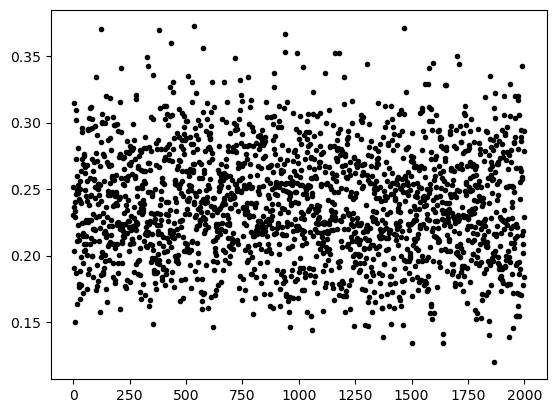

In [35]:
plt.plot(np.arange(len(weight)), weight, '.k')

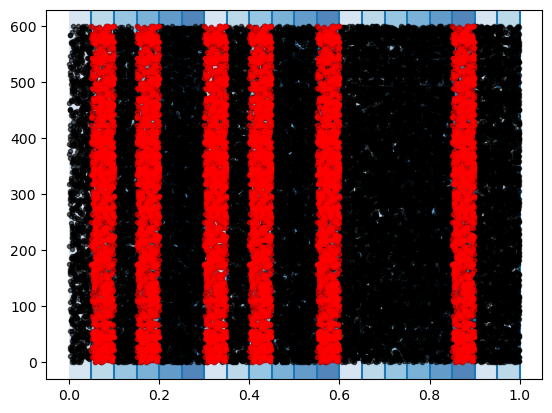

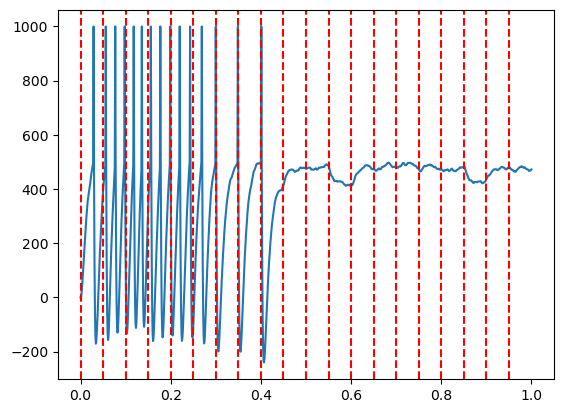

In [37]:
def plot_input(times, indices, times_pattern=None, indices_pattern=None):
    start_time = 0.0
    end_time = 1.0
    # time_limit = 0.01
    index_limit = 600
    sampletimes = times[(times < end_time) & (indices < index_limit) & (times > start_time)]
    sampleindices = indices[(times < end_time) & (indices < index_limit) & (times > start_time)]

    
    # intervals = np.arange(0, 0.61, 0.05)
    intervals = np.arange(start_time, end_time+0.01, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < end_time) & (indices_pattern < index_limit) & (times_pattern > start_time)]
        sampleindicespattern = indices_pattern[(times_pattern < end_time) & (indices_pattern < index_limit) & (times_pattern > start_time)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    plt.show()

    plt.plot(np.arange(0,1.001,0.001), model.potential_rec[000:])
    for x in np.arange(0,1, 0.05):
        plt.axvline(x, color='red', linestyle='--')
    plt.show()

plot_input(times, indices, times_pattern, indices_pattern)

In [47]:
model.potential_rec[150:200]

[450.09107913881576,
 450.61830942096935,
 446.7032194432102,
 437.85882513226125,
 429.8387281938942,
 420.6840251317344,
 412.3072258485587,
 405.1366019762228,
 396.0932501222301,
 390.6774367573449,
 387.8675210555544,
 382.9539505709678,
 378.56901421665344,
 374.6422801362372,
 371.3524269577369,
 370.67403158143674,
 370.6577569479334,
 371.27936241054044,
 370.38217613557714,
 368.5919437065901,
 371.2674492530277,
 372.08793606053837,
 373.40796668079565,
 373.57493449298323,
 374.9234798689565,
 375.5317422188143,
 375.67191708276494,
 372.2229631108938,
 370.71343779064955,
 369.0129561756704,
 367.01423027774865,
 365.3688624525895,
 360.9243888662488,
 360.1086146693714,
 361.5193513505615,
 362.1143190243831,
 362.43160472467287,
 365.39978926295447,
 370.82579569970255,
 373.56417468799873,
 378.3588811737684,
 380.2422474440511,
 380.5364823722369,
 382.45113208619046,
 385.28854436910393,
 390.71857855226403,
 395.428803080997,
 399.790439167421,
 405.21844508117783,
 

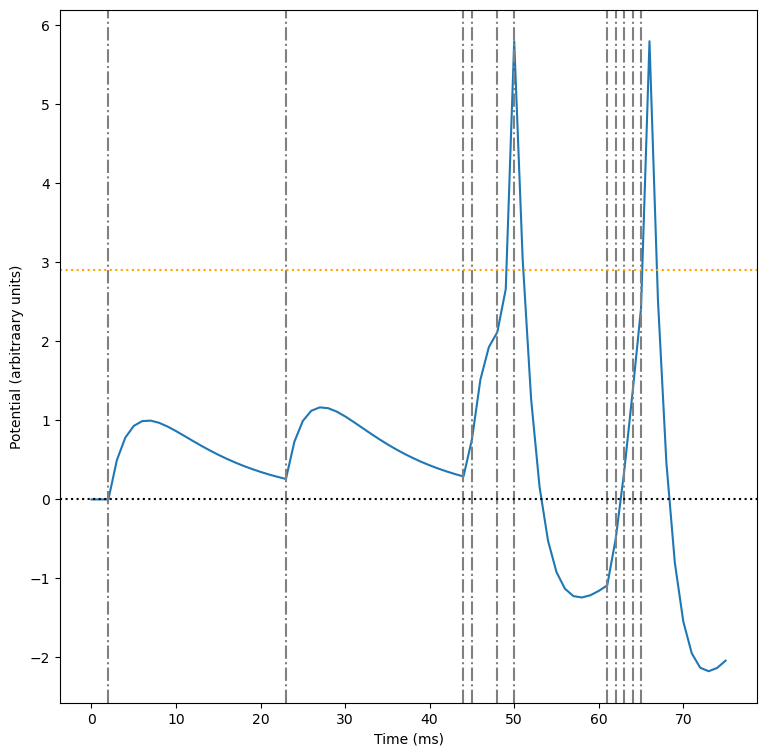

In [17]:
model.plot_membrane_potential_(spike_train)
# model.potential_rec[50], model.potential_rec[51], model.spike_rec

In [53]:
model.spike_rec, model.potential_rec[50], model.potential_rec[51]

([0.051000000000000004, 0.053], 2.908342453265573, 5.8)

(2.908342453265573, 5.8)

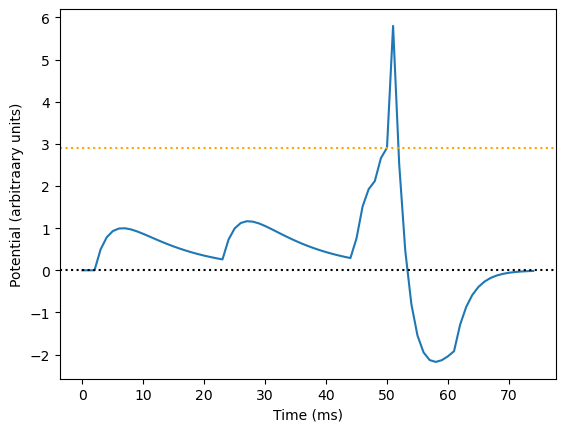

In [12]:
model.plot_membrane_potential_()
model.potential_rec[50], model.potential_rec[51]

In [19]:
# model.plot_kernel_('eps', 0.05, 0.001)
# model.plot_kernel_('eta', 0.05, 0.001)

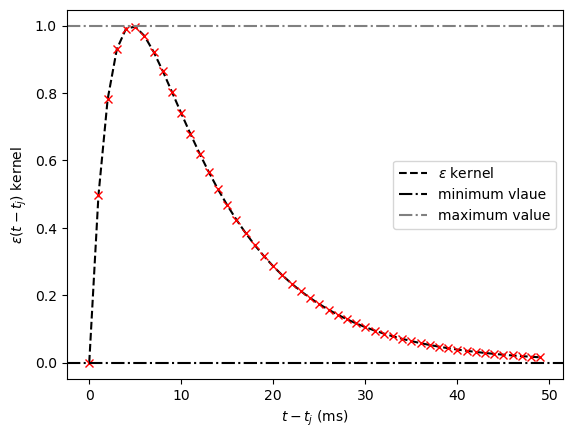

In [90]:
model.plot_kernel_('eps', 0.05, 0.001)

## STDP learning rule

In [10]:
# What do I have? 
print(f'weight = \n{weight}\n')
print(f'spike_train = \n{spike_train}\n')
print(f'spike_rec =\n{model.spike_rec}\n')
print(f'potential_rec =\n{model.potential_rec}\n')


weight = 
[[2.]
 [1.]]

spike_train = 
[[1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

spike_rec =
[0.004]

potential_rec =
[0.0, 0.9927283280483357, 2.556431763768991, 3.424662406363872, 5.8, 2.527655509404851, 0.46357761590747554, -0.8028928217724188, -1.5458566582687059]



for now I am coding LTP and LTD for all spike train. Meaning that when a postsynaptic spike happens (t_i), I consider all the presynaptic spikes (t_j) before it (t_j < t_i) and all the presynaptic spikes after it time (t_j > t_i). 

Also, for each presynaptic neuron (afferent), the code should only consider the last spike of that afferent before the postsynaptic one for LTP.
And limit the LTD to the first presynaptic spike after the postsynaptic one for LTD. 

`this is called 'nearest spike approximation'`

Later on I should change the code so that I consider a learning window of [t_i-7*tau_pos, t_i] for LTP and [t_i, t_i+7*tau_neg] for LTD.

In [144]:
pprint(spike_train[:, :51])
stdp.do_ltp(spike_train[:, :51], 0.049, 0.001)

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
 [0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0]
└────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
afferent_previous_spike time:
┌───────┐
 [0.05 ]
 [0.048]
└───────┘
t_j - t_i (ms)
┌────────┐
 [0.001 ]
 [-0.001]
└────────┘
dw
┌────────┐
 [0.0332]
 [0.0294]
└────────┘


array([[0.03316659],
       [0.02944416]])

In [81]:
t/1000

array([[-0.001],
       [-0.002],
       [  -inf],
       [-0.004]])

In [79]:
0.03125 * np.exp(-0.001/0.0168)
stdp.ltp(-0.001)

0.029444159364966572

In [12]:
stdp.delta_w()

[0.05, 0.066]


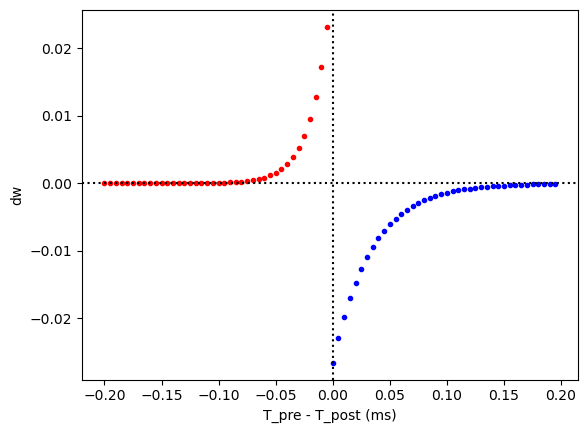

In [58]:
stdp.plot_stdp_(range=0.2, stepsize=0.005)

## Questions to ask: 

-  when the membrane potential of postsynaptic neuron goes above the threshold, let's say at 3 ms, will it fire at 3 ms? Or it will at the next time step i.e. 4 ms? Why?

    If it fires at 4 ms, then what is happening to the incoming spikes also at 4 ms? Does the neuron ignore them (my current srm model ignot)

- Where the hyperparameters come from? [list all the hyperparameters like tau_pos, A_pos, restricted learning window (-7*tau_pos, +7*tau_neg)] and ...

## Adding more features
Now we have two presynaptic neurons (neuron 1 and 2) and one postsynaptic neuron 3. 
neuron 1 and 2 are connected to neuron 3 with synaptic weights equal to 10 and 20 respectively.

the model should go through all the input spike train one step at a time (one time step) to check 
if the neuron 2 has been reached to its threshold or not. if so do the steps below:

- `reset membrane potential`
- ...
- ...
- ... 

In [7]:
# spike_train = np.array([[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                        # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=int)
####### like in the paper fig.3 
spike_train = np.zeros((2,75))
spike_train[0, [2,23,44]] = 1
spike_train[1, [45,45,61]] = 1
# spike_train[0, 2] = 1
####################################

n, ind_run_time = spike_train.shape
weight = np.array([1.4,1.3], dtype=float).reshape(n,1)

spike_rec = np.zeros(ind_run_time+1, dtype=int)
potential_rec = np.zeros(ind_run_time, dtype=float)

In [8]:
dt = 0.001 
tau_m = 0.010
tau_s = 0.0025

K = find_max_and_K(tau_m, tau_s)
threshold = 2.9
T = threshold # threshold # threshold of the neuron! why it is equal to 500 in the paper?
K1 = 2
K2 = 4

last_spike_post = -10000 # ms or seconds?
tref = 1 * dt # refractory duration [second]
tref_counter = 0

# TODO: leter on I should implement the spike_window such that
# it considers different time windows explained in the paper.
# those time windows are based on time (ms) not the number of input spikes implemented here. 
spike_window = 1000
